# Importing Libraries

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from keras.layers.core import Dense, Dropout, Activation
from sklearn.metrics import mean_absolute_error
from keras.layers import BatchNormalization
from keras.layers import Input
from keras.models import Model
import keras
import sys, time
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import nibabel as nib
from nilearn import plotting
import pandas as pd

%matplotlib inline

Using TensorFlow backend.


# Reading Dataset

In [11]:
# load dataset
BASE_PATH = "Horikawa_approach_data/"

X_imagery = np.load(BASE_PATH + "Subject1_VC.npy")
y_imagery = np.load("Selected_Data/VC_y_test.npy")

X_imagery = X_imagery.reshape((X_imagery.shape[1], X_imagery.shape[0]*X_imagery.shape[2]))
print(X_imagery.shape)
print(y_imagery.shape)

(500, 13000)
(500, 1)


In [12]:
def preProcessData(X, y, mode):
    scaler = StandardScaler()
    encoder = LabelEncoder()
    if (mode == "Combined"):
        scaler.fit(X)
        X = scaler.transform(X)
        # encode class values as integers
        encoder.fit(y)
        y = encoder.transform(y)
        
        print(f"[{mode}] X: {X.shape}, y: {y.shape}")
        print(f"Number of classes in y: {len(np.unique(y))}")
        
        return X, y
    
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)

        # encode class values as integers

        encoder.fit(y_train)
        y_train = encoder.transform(y_train)
        y_test = encoder.transform(y_test)

        print(f"[{mode}] Train_X: {X_train.shape}, Train_y: {y_train.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}")
        print(f"Number of classes in Train: {len(np.unique(y_train))} , Number of classes in Test: {len(np.unique(y_test))}")

        return X_train, X_test, y_train, y_test

### Get Perception (pt) & Imagery (im) Data

In [13]:
# X_train_pt, X_test_pt, y_train_pt, y_test_pt = preProcessData(X_percept, y_percept, "Perception")
X_train_im, X_test_im, y_train_im, y_test_im = preProcessData(X_imagery, y_imagery, "Imagery")

# combine data
# combined_X = np.concatenate((X_train_pt, X_train_im), axis=0)
# combined_y = np.hstack((y_train_pt, y_train_im))

# combined_X, combined_y = shuffle(combined_X, combined_y) # since they are concatenated at the last, shuffle and preserve indices
# X_train_cb, y_train_cb = preProcessData(combined_X, combined_y, "Combined")

[Imagery] Train_X: (335, 13000), Train_y: (335,), X_test: (165, 13000), y_test: (165,)
Number of classes in Train: 50 , Number of classes in Test: 50


# Training

## Logistic Regression

In [15]:
def logReg(X_train, X_test, y_train, y_test):
    clf = LogisticRegression(verbose=2).fit(X_train, y_train)
    predictions = clf.predict(X_test)
    accuracy = accuracy_score(predictions, y_test)
    return accuracy

### Experiment A. (Perception Train Perception Test)

In [17]:
accuracy_logReg_a = logReg(X_train_pt, X_test_pt, y_train_pt, y_test_pt)
print(f"Accuracy: {accuracy_logReg_a}")

[LibLinear]Accuracy: 0.14742917103882477


### Experiment B. (Imagery Train Imagery Test) 

In [16]:
accuracy_logReg_b = logReg(X_train_im, X_test_im, y_train_im, y_test_im)
print(f"Accuracy: {accuracy_logReg_b}")

[LibLinear]Accuracy: 0.0


### Experiment C. (Perception Train Imagery Test) 

In [19]:
accuracy_logReg_c = logReg(X_train_pt, X_test_im, y_train_pt, y_test_im)
print(f"Accuracy: {accuracy_logReg_c}")

[LibLinear]Accuracy: 0.02181818181818182


### Experiment D. (Combined Train Combined Test) 

In [20]:
accuracy_logReg_d_im = logReg(X_train_cb, X_test_im, y_train_cb, y_test_im)
print(f"Imagery Accuracy: {accuracy_logReg_d_im}")

accuracy_logReg_d_pt = logReg(X_train_cb, X_test_pt, y_train_cb, y_test_pt)
print(f"Perception Accuracy: {accuracy_logReg_d_pt}")

[LibLinear]Imagery Accuracy: 0.3296969696969697
[LibLinear]Perception Accuracy: 0.14428121720881426


## AlexNet

In [17]:
def alexNet(pretrained_weights = None,input_size = (4466,)):
    
    inputs = Input(input_size)
    dense1 = Dense(64, activation='relu', kernel_initializer = 'he_normal')(inputs)
    bn1 = BatchNormalization()(dense1)
    dropout1 = Dropout(0.5)(bn1)
    dense2 = Dense(128, activation='relu', kernel_initializer = 'he_normal')(dropout1)
    bn2 = BatchNormalization()(dense2)
    dropout2 = Dropout(0.5)(bn2)
    dense3 = Dense(512, activation='relu',kernel_initializer = 'he_normal')(dropout2)
    bn3 = BatchNormalization()(dense3)
    dropout3 = Dropout(0.5)(bn3)
    dense4 = Dense(512, activation='relu',kernel_initializer = 'he_normal')(dropout3)
    dense5 = Dense(256, activation='relu',kernel_initializer = 'he_normal')(dense4)
    dropout4 = Dropout(0.5)(dense5)
    dense6 = Dense(128, activation='relu',kernel_initializer = 'he_normal')(dropout4)
    dense7 = Dense(64, activation='relu',kernel_initializer = 'he_normal')(dense6)
    bn7 = BatchNormalization()(dense7)

    dense8 = Dense(50, activation='softmax')(bn7)
    model = Model(input = inputs, output = dense8)
    model.compile(loss='sparse_categorical_crossentropy', optimizer = keras.optimizers.Adam(lr = 1e-4), metrics=['accuracy'])
    
    if(pretrained_weights):
        print('loading_weights')
        model.load_weights(pretrained_weights)

    return model

In [18]:
def fit_alexNet(X_train, X_test, y_train, y_test):
    model = alexNet(input_size=(X_train.shape[1],))
    print(model.summary())
    model = alexNet(input_size=(X_train.shape[1],))
    history = model.fit(X_train, y_train, batch_size=64, epochs=500, validation_data=(X_test, y_test), shuffle=True, verbose=2)
    
    score = model.evaluate(X_test, y_test, batch_size=16)    
    return score, history

def plot_acc(history, file_name):
    plt.plot(history.history['acc'], label="train")
    plt.plot(history.history['val_acc'], label="val")
    plt.title("Accuracy Curve Train vs Val")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.savefig(file_name, dpi=300)
    plt.show()
    
def plot_loss(history, file_name):
    plt.plot(history.history['loss'], label="train")
    plt.plot(history.history['val_loss'], label="val")
    plt.title("Loss Curve Train vs Test")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(file_name, dpi=300)
    plt.show()

### Experiment A. (Perception Train Perception Test)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 4794)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                306880    
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0   

Epoch 67/500
 - 1s - loss: 3.9177 - acc: 0.0246 - val_loss: 3.9189 - val_acc: 0.0184
Epoch 68/500
 - 1s - loss: 3.9200 - acc: 0.0165 - val_loss: 3.9187 - val_acc: 0.0184
Epoch 69/500
 - 1s - loss: 3.9130 - acc: 0.0274 - val_loss: 3.9189 - val_acc: 0.0194
Epoch 70/500
 - 1s - loss: 3.9174 - acc: 0.0207 - val_loss: 3.9185 - val_acc: 0.0173
Epoch 71/500
 - 1s - loss: 3.9184 - acc: 0.0235 - val_loss: 3.9188 - val_acc: 0.0178
Epoch 72/500
 - 1s - loss: 3.9146 - acc: 0.0233 - val_loss: 3.9184 - val_acc: 0.0168
Epoch 73/500
 - 1s - loss: 3.9175 - acc: 0.0258 - val_loss: 3.9184 - val_acc: 0.0215
Epoch 74/500
 - 1s - loss: 3.9166 - acc: 0.0217 - val_loss: 3.9184 - val_acc: 0.0194
Epoch 75/500
 - 1s - loss: 3.9138 - acc: 0.0258 - val_loss: 3.9183 - val_acc: 0.0178
Epoch 76/500
 - 1s - loss: 3.9115 - acc: 0.0256 - val_loss: 3.9182 - val_acc: 0.0199
Epoch 77/500
 - 1s - loss: 3.9183 - acc: 0.0204 - val_loss: 3.9182 - val_acc: 0.0184
Epoch 78/500
 - 1s - loss: 3.9177 - acc: 0.0248 - val_loss: 3.918

Epoch 163/500
 - 2s - loss: 3.8744 - acc: 0.0274 - val_loss: 3.9287 - val_acc: 0.0189
Epoch 164/500
 - 2s - loss: 3.8737 - acc: 0.0308 - val_loss: 3.9287 - val_acc: 0.0205
Epoch 165/500
 - 2s - loss: 3.8762 - acc: 0.0318 - val_loss: 3.9302 - val_acc: 0.0226
Epoch 166/500
 - 2s - loss: 3.8779 - acc: 0.0328 - val_loss: 3.9303 - val_acc: 0.0215
Epoch 167/500
 - 2s - loss: 3.8737 - acc: 0.0318 - val_loss: 3.9314 - val_acc: 0.0184
Epoch 168/500
 - 2s - loss: 3.8689 - acc: 0.0274 - val_loss: 3.9298 - val_acc: 0.0189
Epoch 169/500
 - 1s - loss: 3.8684 - acc: 0.0331 - val_loss: 3.9314 - val_acc: 0.0210
Epoch 170/500
 - 1s - loss: 3.8680 - acc: 0.0295 - val_loss: 3.9364 - val_acc: 0.0205
Epoch 171/500
 - 1s - loss: 3.8642 - acc: 0.0336 - val_loss: 3.9371 - val_acc: 0.0220
Epoch 172/500
 - 1s - loss: 3.8563 - acc: 0.0315 - val_loss: 3.9384 - val_acc: 0.0252
Epoch 173/500
 - 1s - loss: 3.8621 - acc: 0.0313 - val_loss: 3.9432 - val_acc: 0.0220
Epoch 174/500
 - 1s - loss: 3.8619 - acc: 0.0395 - val

Epoch 259/500
 - 2s - loss: 3.5223 - acc: 0.0791 - val_loss: 4.2073 - val_acc: 0.0283
Epoch 260/500
 - 2s - loss: 3.5121 - acc: 0.0809 - val_loss: 4.1730 - val_acc: 0.0241
Epoch 261/500
 - 2s - loss: 3.5242 - acc: 0.0796 - val_loss: 4.1259 - val_acc: 0.0320
Epoch 262/500
 - 2s - loss: 3.5129 - acc: 0.0837 - val_loss: 4.1644 - val_acc: 0.0289
Epoch 263/500
 - 2s - loss: 3.5070 - acc: 0.0874 - val_loss: 4.1901 - val_acc: 0.0273
Epoch 264/500
 - 1s - loss: 3.5106 - acc: 0.0866 - val_loss: 4.2077 - val_acc: 0.0304
Epoch 265/500
 - 1s - loss: 3.5019 - acc: 0.0902 - val_loss: 4.2106 - val_acc: 0.0283
Epoch 266/500
 - 1s - loss: 3.5014 - acc: 0.0793 - val_loss: 4.1938 - val_acc: 0.0289
Epoch 267/500
 - 1s - loss: 3.4879 - acc: 0.0801 - val_loss: 4.1554 - val_acc: 0.0278
Epoch 268/500
 - 1s - loss: 3.4901 - acc: 0.0788 - val_loss: 4.1681 - val_acc: 0.0273
Epoch 269/500
 - 1s - loss: 3.4880 - acc: 0.0835 - val_loss: 4.2211 - val_acc: 0.0268
Epoch 270/500
 - 1s - loss: 3.4674 - acc: 0.0861 - val

Epoch 355/500
 - 1s - loss: 3.0445 - acc: 0.1476 - val_loss: 4.5440 - val_acc: 0.0383
Epoch 356/500
 - 1s - loss: 3.0430 - acc: 0.1471 - val_loss: 4.5193 - val_acc: 0.0315
Epoch 357/500
 - 1s - loss: 3.0659 - acc: 0.1458 - val_loss: 4.4759 - val_acc: 0.0357
Epoch 358/500
 - 1s - loss: 3.0460 - acc: 0.1458 - val_loss: 4.4617 - val_acc: 0.0357
Epoch 359/500
 - 2s - loss: 3.0287 - acc: 0.1525 - val_loss: 4.5490 - val_acc: 0.0367
Epoch 360/500
 - 2s - loss: 3.0619 - acc: 0.1445 - val_loss: 4.5507 - val_acc: 0.0404
Epoch 361/500
 - 2s - loss: 3.0554 - acc: 0.1440 - val_loss: 4.4843 - val_acc: 0.0399
Epoch 362/500
 - 2s - loss: 3.0310 - acc: 0.1559 - val_loss: 4.5378 - val_acc: 0.0352
Epoch 363/500
 - 2s - loss: 3.0295 - acc: 0.1515 - val_loss: 4.5105 - val_acc: 0.0404
Epoch 364/500
 - 2s - loss: 3.0006 - acc: 0.1628 - val_loss: 4.5024 - val_acc: 0.0420
Epoch 365/500
 - 2s - loss: 3.0213 - acc: 0.1517 - val_loss: 4.5493 - val_acc: 0.0315
Epoch 366/500
 - 2s - loss: 3.0101 - acc: 0.1535 - val

Epoch 451/500
 - 2s - loss: 2.6330 - acc: 0.2282 - val_loss: 4.8479 - val_acc: 0.0456
Epoch 452/500
 - 2s - loss: 2.6172 - acc: 0.2476 - val_loss: 4.8846 - val_acc: 0.0404
Epoch 453/500
 - 2s - loss: 2.6319 - acc: 0.2357 - val_loss: 4.8587 - val_acc: 0.0378
Epoch 454/500
 - 2s - loss: 2.6251 - acc: 0.2342 - val_loss: 4.8859 - val_acc: 0.0404
Epoch 455/500
 - 2s - loss: 2.6165 - acc: 0.2349 - val_loss: 4.9011 - val_acc: 0.0404
Epoch 456/500
 - 2s - loss: 2.6114 - acc: 0.2300 - val_loss: 4.9109 - val_acc: 0.0393
Epoch 457/500
 - 2s - loss: 2.6026 - acc: 0.2437 - val_loss: 4.9001 - val_acc: 0.0420
Epoch 458/500
 - 2s - loss: 2.6167 - acc: 0.2373 - val_loss: 4.9170 - val_acc: 0.0409
Epoch 459/500
 - 2s - loss: 2.6267 - acc: 0.2321 - val_loss: 4.8360 - val_acc: 0.0357
Epoch 460/500
 - 2s - loss: 2.6079 - acc: 0.2313 - val_loss: 4.8236 - val_acc: 0.0435
Epoch 461/500
 - 2s - loss: 2.5964 - acc: 0.2432 - val_loss: 4.9063 - val_acc: 0.0388
Epoch 462/500
 - 2s - loss: 2.6163 - acc: 0.2396 - val

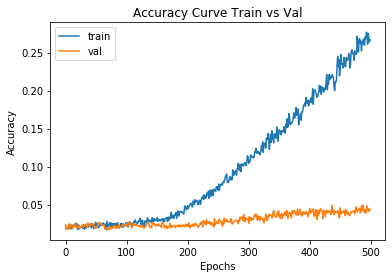

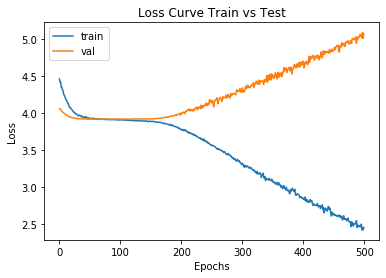

In [23]:
score, history = fit_alexNet(X_train_pt, X_test_pt, y_train_pt, y_test_pt)
print(f"Accuracy: {score}")

file_name = "Results_IMGS/Acc_AlexNet_Perception_Train_Perception_Test.png"
plot_acc(history, file_name)
file_name = "Results_IMGS/Loss_AlexNet_Perception_Train_Perception_Test.png"
plot_loss(history, file_name)

### Experiment B. (Imagery Train Imagery Test)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 13000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                832064    
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0   

 - 0s - loss: 4.2378 - acc: 0.0328 - val_loss: 4.0421 - val_acc: 0.0182
Epoch 67/500
 - 0s - loss: 4.1434 - acc: 0.0299 - val_loss: 4.0412 - val_acc: 0.0182
Epoch 68/500
 - 0s - loss: 4.1997 - acc: 0.0239 - val_loss: 4.0415 - val_acc: 0.0182
Epoch 69/500
 - 0s - loss: 4.1615 - acc: 0.0328 - val_loss: 4.0408 - val_acc: 0.0182
Epoch 70/500
 - 0s - loss: 4.2513 - acc: 0.0269 - val_loss: 4.0384 - val_acc: 0.0182
Epoch 71/500
 - 0s - loss: 4.2484 - acc: 0.0269 - val_loss: 4.0379 - val_acc: 0.0182
Epoch 72/500
 - 0s - loss: 4.2598 - acc: 0.0209 - val_loss: 4.0384 - val_acc: 0.0182
Epoch 73/500
 - 0s - loss: 4.2048 - acc: 0.0179 - val_loss: 4.0405 - val_acc: 0.0182
Epoch 74/500
 - 0s - loss: 4.2371 - acc: 0.0358 - val_loss: 4.0413 - val_acc: 0.0182
Epoch 75/500
 - 0s - loss: 4.1806 - acc: 0.0209 - val_loss: 4.0427 - val_acc: 0.0182
Epoch 76/500
 - 0s - loss: 4.1601 - acc: 0.0209 - val_loss: 4.0427 - val_acc: 0.0182
Epoch 77/500
 - 0s - loss: 4.2496 - acc: 0.0328 - val_loss: 4.0414 - val_acc: 

Epoch 162/500
 - 0s - loss: 4.0687 - acc: 0.0179 - val_loss: 4.0119 - val_acc: 0.0182
Epoch 163/500
 - 0s - loss: 4.0466 - acc: 0.0269 - val_loss: 4.0130 - val_acc: 0.0182
Epoch 164/500
 - 0s - loss: 4.0641 - acc: 0.0209 - val_loss: 4.0132 - val_acc: 0.0182
Epoch 165/500
 - 0s - loss: 4.0674 - acc: 0.0388 - val_loss: 4.0137 - val_acc: 0.0182
Epoch 166/500
 - 0s - loss: 4.0416 - acc: 0.0239 - val_loss: 4.0152 - val_acc: 0.0182
Epoch 167/500
 - 0s - loss: 4.1007 - acc: 0.0239 - val_loss: 4.0179 - val_acc: 0.0182
Epoch 168/500
 - 0s - loss: 4.0809 - acc: 0.0269 - val_loss: 4.0199 - val_acc: 0.0182
Epoch 169/500
 - 0s - loss: 4.0765 - acc: 0.0179 - val_loss: 4.0214 - val_acc: 0.0182
Epoch 170/500
 - 0s - loss: 4.0327 - acc: 0.0269 - val_loss: 4.0228 - val_acc: 0.0182
Epoch 171/500
 - 0s - loss: 3.9694 - acc: 0.0328 - val_loss: 4.0219 - val_acc: 0.0182
Epoch 172/500
 - 0s - loss: 4.0996 - acc: 0.0239 - val_loss: 4.0214 - val_acc: 0.0182
Epoch 173/500
 - 0s - loss: 4.0322 - acc: 0.0209 - val

Epoch 258/500
 - 0s - loss: 3.9138 - acc: 0.0299 - val_loss: 4.0256 - val_acc: 0.0121
Epoch 259/500
 - 0s - loss: 3.9396 - acc: 0.0239 - val_loss: 4.0269 - val_acc: 0.0121
Epoch 260/500
 - 0s - loss: 3.9348 - acc: 0.0299 - val_loss: 4.0269 - val_acc: 0.0121
Epoch 261/500
 - 0s - loss: 3.9530 - acc: 0.0269 - val_loss: 4.0268 - val_acc: 0.0121
Epoch 262/500
 - 0s - loss: 4.0005 - acc: 0.0179 - val_loss: 4.0264 - val_acc: 0.0121
Epoch 263/500
 - 0s - loss: 3.9014 - acc: 0.0269 - val_loss: 4.0246 - val_acc: 0.0121
Epoch 264/500
 - 0s - loss: 3.9580 - acc: 0.0299 - val_loss: 4.0249 - val_acc: 0.0121
Epoch 265/500
 - 0s - loss: 3.8879 - acc: 0.0358 - val_loss: 4.0249 - val_acc: 0.0121
Epoch 266/500
 - 0s - loss: 3.9063 - acc: 0.0269 - val_loss: 4.0254 - val_acc: 0.0121
Epoch 267/500
 - 0s - loss: 3.9821 - acc: 0.0209 - val_loss: 4.0244 - val_acc: 0.0121
Epoch 268/500
 - 0s - loss: 3.9450 - acc: 0.0209 - val_loss: 4.0222 - val_acc: 0.0121
Epoch 269/500
 - 0s - loss: 3.9237 - acc: 0.0358 - val

Epoch 354/500
 - 0s - loss: 3.8168 - acc: 0.0328 - val_loss: 4.0280 - val_acc: 0.0121
Epoch 355/500
 - 0s - loss: 3.8091 - acc: 0.0328 - val_loss: 4.0296 - val_acc: 0.0121
Epoch 356/500
 - 0s - loss: 3.8143 - acc: 0.0388 - val_loss: 4.0305 - val_acc: 0.0121
Epoch 357/500
 - 0s - loss: 3.9171 - acc: 0.0239 - val_loss: 4.0304 - val_acc: 0.0121
Epoch 358/500
 - 0s - loss: 3.8361 - acc: 0.0597 - val_loss: 4.0303 - val_acc: 0.0121
Epoch 359/500
 - 0s - loss: 3.8302 - acc: 0.0716 - val_loss: 4.0298 - val_acc: 0.0121
Epoch 360/500
 - 0s - loss: 3.8219 - acc: 0.0358 - val_loss: 4.0291 - val_acc: 0.0121
Epoch 361/500
 - 0s - loss: 3.8334 - acc: 0.0507 - val_loss: 4.0288 - val_acc: 0.0121
Epoch 362/500
 - 0s - loss: 3.8175 - acc: 0.0478 - val_loss: 4.0294 - val_acc: 0.0121
Epoch 363/500
 - 0s - loss: 3.8207 - acc: 0.0418 - val_loss: 4.0298 - val_acc: 0.0121
Epoch 364/500
 - 0s - loss: 3.8304 - acc: 0.0448 - val_loss: 4.0303 - val_acc: 0.0121
Epoch 365/500
 - 0s - loss: 3.8373 - acc: 0.0537 - val

Epoch 450/500
 - 0s - loss: 3.7507 - acc: 0.0418 - val_loss: 4.0250 - val_acc: 0.0121
Epoch 451/500
 - 0s - loss: 3.7822 - acc: 0.0567 - val_loss: 4.0247 - val_acc: 0.0121
Epoch 452/500
 - 0s - loss: 3.7550 - acc: 0.0448 - val_loss: 4.0243 - val_acc: 0.0121
Epoch 453/500
 - 0s - loss: 3.7694 - acc: 0.0627 - val_loss: 4.0248 - val_acc: 0.0121
Epoch 454/500
 - 0s - loss: 3.7372 - acc: 0.0537 - val_loss: 4.0255 - val_acc: 0.0121
Epoch 455/500
 - 0s - loss: 3.7396 - acc: 0.0507 - val_loss: 4.0260 - val_acc: 0.0121
Epoch 456/500
 - 0s - loss: 3.7456 - acc: 0.0507 - val_loss: 4.0258 - val_acc: 0.0121
Epoch 457/500
 - 0s - loss: 3.8025 - acc: 0.0269 - val_loss: 4.0262 - val_acc: 0.0121
Epoch 458/500
 - 0s - loss: 3.7432 - acc: 0.0687 - val_loss: 4.0269 - val_acc: 0.0121
Epoch 459/500
 - 0s - loss: 3.7159 - acc: 0.0478 - val_loss: 4.0282 - val_acc: 0.0121
Epoch 460/500
 - 0s - loss: 3.7705 - acc: 0.0448 - val_loss: 4.0300 - val_acc: 0.0121
Epoch 461/500
 - 0s - loss: 3.7585 - acc: 0.0507 - val

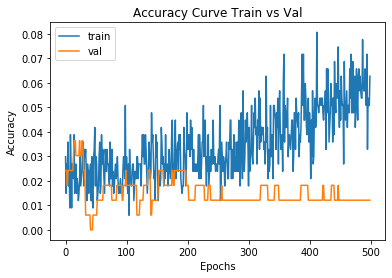

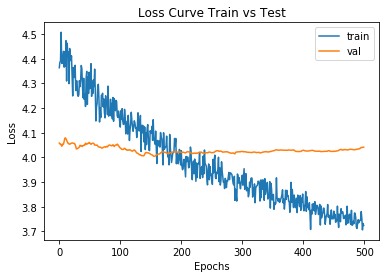

In [19]:
score, history = fit_alexNet(X_train_im, X_test_im, y_train_im, y_test_im)
print(f"Accuracy: {score}")
file_name = "Results_IMGS/Acc_AlexNet_Imagery_Train_Imagery_Test.png"
plot_acc(history, file_name)
file_name = "Results_IMGS/Loss_AlexNet_Imagery_Train_Imagery_Test.png"
plot_loss(history, file_name)

### Experiment C. (Perception Train Imagery Test)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 4794)              0         
_________________________________________________________________
dense_33 (Dense)             (None, 64)                306880    
_________________________________________________________________
batch_normalization_17 (Batc (None, 64)                256       
_________________________________________________________________
dropout_17 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_34 (Dense)             (None, 128)               8320      
_________________________________________________________________
batch_normalization_18 (Batc (None, 128)               512       
_________________________________________________________________
dropout_18 (Dropout)         (None, 128)               0   

Epoch 67/500
 - 2s - loss: 3.9287 - acc: 0.0204 - val_loss: 3.9151 - val_acc: 0.0158
Epoch 68/500
 - 2s - loss: 3.9221 - acc: 0.0279 - val_loss: 3.9156 - val_acc: 0.0182
Epoch 69/500
 - 2s - loss: 3.9226 - acc: 0.0243 - val_loss: 3.9151 - val_acc: 0.0182
Epoch 70/500
 - 2s - loss: 3.9224 - acc: 0.0194 - val_loss: 3.9145 - val_acc: 0.0194
Epoch 71/500
 - 2s - loss: 3.9248 - acc: 0.0235 - val_loss: 3.9140 - val_acc: 0.0242
Epoch 72/500
 - 2s - loss: 3.9221 - acc: 0.0238 - val_loss: 3.9144 - val_acc: 0.0170
Epoch 73/500
 - 1s - loss: 3.9187 - acc: 0.0217 - val_loss: 3.9144 - val_acc: 0.0206
Epoch 74/500
 - 1s - loss: 3.9227 - acc: 0.0196 - val_loss: 3.9141 - val_acc: 0.0218
Epoch 75/500
 - 1s - loss: 3.9260 - acc: 0.0230 - val_loss: 3.9140 - val_acc: 0.0194
Epoch 76/500
 - 1s - loss: 3.9131 - acc: 0.0240 - val_loss: 3.9146 - val_acc: 0.0242
Epoch 77/500
 - 1s - loss: 3.9199 - acc: 0.0235 - val_loss: 3.9151 - val_acc: 0.0170
Epoch 78/500
 - 1s - loss: 3.9128 - acc: 0.0225 - val_loss: 3.915

Epoch 163/500
 - 2s - loss: 3.8492 - acc: 0.0411 - val_loss: 3.9630 - val_acc: 0.0206
Epoch 164/500
 - 2s - loss: 3.8501 - acc: 0.0370 - val_loss: 3.9679 - val_acc: 0.0194
Epoch 165/500
 - 2s - loss: 3.8445 - acc: 0.0388 - val_loss: 3.9645 - val_acc: 0.0194
Epoch 166/500
 - 2s - loss: 3.8390 - acc: 0.0414 - val_loss: 3.9693 - val_acc: 0.0206
Epoch 167/500
 - 2s - loss: 3.8390 - acc: 0.0395 - val_loss: 3.9764 - val_acc: 0.0170
Epoch 168/500
 - 1s - loss: 3.8403 - acc: 0.0447 - val_loss: 3.9784 - val_acc: 0.0158
Epoch 169/500
 - 1s - loss: 3.8367 - acc: 0.0370 - val_loss: 3.9809 - val_acc: 0.0218
Epoch 170/500
 - 1s - loss: 3.8223 - acc: 0.0437 - val_loss: 3.9825 - val_acc: 0.0158
Epoch 171/500
 - 1s - loss: 3.8343 - acc: 0.0439 - val_loss: 3.9856 - val_acc: 0.0182
Epoch 172/500
 - 1s - loss: 3.8293 - acc: 0.0385 - val_loss: 3.9865 - val_acc: 0.0158
Epoch 173/500
 - 1s - loss: 3.8193 - acc: 0.0450 - val_loss: 3.9923 - val_acc: 0.0194
Epoch 174/500
 - 1s - loss: 3.8227 - acc: 0.0414 - val

Epoch 259/500
 - 1s - loss: 3.3938 - acc: 0.1093 - val_loss: 4.7370 - val_acc: 0.0206
Epoch 260/500
 - 1s - loss: 3.4034 - acc: 0.0982 - val_loss: 4.7416 - val_acc: 0.0194
Epoch 261/500
 - 2s - loss: 3.3755 - acc: 0.1052 - val_loss: 4.7765 - val_acc: 0.0170
Epoch 262/500
 - 2s - loss: 3.3753 - acc: 0.1088 - val_loss: 4.7852 - val_acc: 0.0182
Epoch 263/500
 - 2s - loss: 3.3778 - acc: 0.1091 - val_loss: 4.7618 - val_acc: 0.0170
Epoch 264/500
 - 2s - loss: 3.3585 - acc: 0.1086 - val_loss: 4.8029 - val_acc: 0.0145
Epoch 265/500
 - 2s - loss: 3.3610 - acc: 0.1080 - val_loss: 4.7992 - val_acc: 0.0145
Epoch 266/500
 - 2s - loss: 3.3604 - acc: 0.1176 - val_loss: 4.7646 - val_acc: 0.0182
Epoch 267/500
 - 2s - loss: 3.3621 - acc: 0.1127 - val_loss: 4.8272 - val_acc: 0.0182
Epoch 268/500
 - 2s - loss: 3.3675 - acc: 0.1067 - val_loss: 4.8594 - val_acc: 0.0133
Epoch 269/500
 - 2s - loss: 3.3401 - acc: 0.1122 - val_loss: 4.8602 - val_acc: 0.0121
Epoch 270/500
 - 2s - loss: 3.3363 - acc: 0.1135 - val

Epoch 355/500
 - 2s - loss: 2.8647 - acc: 0.1817 - val_loss: 5.6954 - val_acc: 0.0121
Epoch 356/500
 - 2s - loss: 2.8873 - acc: 0.1827 - val_loss: 5.7382 - val_acc: 0.0145
Epoch 357/500
 - 2s - loss: 2.8686 - acc: 0.1861 - val_loss: 5.7195 - val_acc: 0.0121
Epoch 358/500
 - 2s - loss: 2.8943 - acc: 0.1879 - val_loss: 5.7773 - val_acc: 0.0133
Epoch 359/500
 - 2s - loss: 2.8871 - acc: 0.1895 - val_loss: 5.8322 - val_acc: 0.0121
Epoch 360/500
 - 2s - loss: 2.8553 - acc: 0.1988 - val_loss: 5.7116 - val_acc: 0.0158
Epoch 361/500
 - 2s - loss: 2.8763 - acc: 0.1874 - val_loss: 5.7451 - val_acc: 0.0170
Epoch 362/500
 - 2s - loss: 2.8744 - acc: 0.1897 - val_loss: 5.7543 - val_acc: 0.0121
Epoch 363/500
 - 1s - loss: 2.8755 - acc: 0.1949 - val_loss: 5.7726 - val_acc: 0.0109
Epoch 364/500
 - 2s - loss: 2.8723 - acc: 0.1889 - val_loss: 5.7900 - val_acc: 0.0170
Epoch 365/500
 - 1s - loss: 2.8758 - acc: 0.1856 - val_loss: 5.8079 - val_acc: 0.0109
Epoch 366/500
 - 1s - loss: 2.8540 - acc: 0.1920 - val

Epoch 451/500
 - 2s - loss: 2.4991 - acc: 0.2639 - val_loss: 6.5989 - val_acc: 0.0158
Epoch 452/500
 - 2s - loss: 2.4617 - acc: 0.2768 - val_loss: 6.6031 - val_acc: 0.0182
Epoch 453/500
 - 2s - loss: 2.4471 - acc: 0.2786 - val_loss: 6.6242 - val_acc: 0.0145
Epoch 454/500
 - 2s - loss: 2.4442 - acc: 0.2797 - val_loss: 6.5892 - val_acc: 0.0182
Epoch 455/500
 - 2s - loss: 2.4546 - acc: 0.2742 - val_loss: 6.6340 - val_acc: 0.0170
Epoch 456/500
 - 2s - loss: 2.4319 - acc: 0.2887 - val_loss: 6.7237 - val_acc: 0.0133
Epoch 457/500
 - 2s - loss: 2.4371 - acc: 0.2768 - val_loss: 6.6857 - val_acc: 0.0170
Epoch 458/500
 - 2s - loss: 2.4328 - acc: 0.2727 - val_loss: 6.6574 - val_acc: 0.0170
Epoch 459/500
 - 1s - loss: 2.4634 - acc: 0.2758 - val_loss: 6.6601 - val_acc: 0.0158
Epoch 460/500
 - 1s - loss: 2.4431 - acc: 0.2773 - val_loss: 6.7079 - val_acc: 0.0170
Epoch 461/500
 - 1s - loss: 2.4241 - acc: 0.2833 - val_loss: 6.7496 - val_acc: 0.0158
Epoch 462/500
 - 1s - loss: 2.4397 - acc: 0.2954 - val

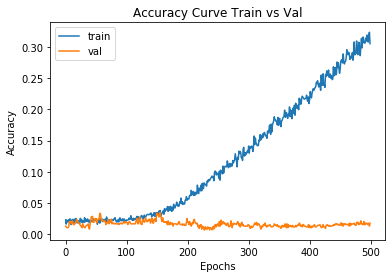

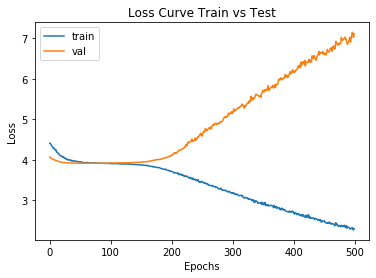

In [25]:
score, history = fit_alexNet(X_train_pt, X_test_im, y_train_pt, y_test_im)
print(f"Accuracy: {score}")
file_name = "Results_IMGS/Acc_AlexNet_Perception_Train_Imagery_Test.png"
plot_acc(history, file_name)
file_name = "Results_IMGS/Loss_AlexNet_Perception_Train_Imagery_Test.png"
plot_loss(history, file_name)

### Experiment D. (Combined Train Combined Test)

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 4794)              0         
_________________________________________________________________
dense_49 (Dense)             (None, 64)                306880    
_________________________________________________________________
batch_normalization_25 (Batc (None, 64)                256       
_________________________________________________________________
dropout_25 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_50 (Dense)             (None, 128)               8320      
_________________________________________________________________
batch_normalization_26 (Batc (None, 128)               512       
_________________________________________________________________
dropout_26 (Dropout)         (None, 128)               0   

Epoch 67/500
 - 2s - loss: 3.9014 - acc: 0.0260 - val_loss: 3.9013 - val_acc: 0.0279
Epoch 68/500
 - 2s - loss: 3.9009 - acc: 0.0283 - val_loss: 3.9001 - val_acc: 0.0255
Epoch 69/500
 - 2s - loss: 3.9019 - acc: 0.0249 - val_loss: 3.8985 - val_acc: 0.0242
Epoch 70/500
 - 2s - loss: 3.8985 - acc: 0.0271 - val_loss: 3.8977 - val_acc: 0.0291
Epoch 71/500
 - 2s - loss: 3.8968 - acc: 0.0287 - val_loss: 3.8992 - val_acc: 0.0267
Epoch 72/500
 - 2s - loss: 3.8982 - acc: 0.0314 - val_loss: 3.8991 - val_acc: 0.0291
Epoch 73/500
 - 2s - loss: 3.8968 - acc: 0.0285 - val_loss: 3.8986 - val_acc: 0.0267
Epoch 74/500
 - 2s - loss: 3.8965 - acc: 0.0290 - val_loss: 3.8980 - val_acc: 0.0303
Epoch 75/500
 - 2s - loss: 3.8942 - acc: 0.0269 - val_loss: 3.8977 - val_acc: 0.0267
Epoch 76/500
 - 2s - loss: 3.8951 - acc: 0.0307 - val_loss: 3.9045 - val_acc: 0.0303
Epoch 77/500
 - 2s - loss: 3.8916 - acc: 0.0326 - val_loss: 3.8976 - val_acc: 0.0279
Epoch 78/500
 - 2s - loss: 3.8952 - acc: 0.0310 - val_loss: 3.901

Epoch 163/500
 - 3s - loss: 3.6407 - acc: 0.0653 - val_loss: 3.8938 - val_acc: 0.0400
Epoch 164/500
 - 2s - loss: 3.6201 - acc: 0.0702 - val_loss: 3.9125 - val_acc: 0.0327
Epoch 165/500
 - 2s - loss: 3.6173 - acc: 0.0727 - val_loss: 3.9113 - val_acc: 0.0327
Epoch 166/500
 - 3s - loss: 3.6216 - acc: 0.0707 - val_loss: 3.9327 - val_acc: 0.0400
Epoch 167/500
 - 2s - loss: 3.6075 - acc: 0.0703 - val_loss: 3.9194 - val_acc: 0.0364
Epoch 168/500
 - 2s - loss: 3.6135 - acc: 0.0727 - val_loss: 3.8869 - val_acc: 0.0388
Epoch 169/500
 - 2s - loss: 3.5990 - acc: 0.0700 - val_loss: 3.9023 - val_acc: 0.0364
Epoch 170/500
 - 2s - loss: 3.5917 - acc: 0.0758 - val_loss: 3.9101 - val_acc: 0.0303
Epoch 171/500
 - 2s - loss: 3.5930 - acc: 0.0777 - val_loss: 3.9117 - val_acc: 0.0412
Epoch 172/500
 - 2s - loss: 3.5961 - acc: 0.0776 - val_loss: 3.9070 - val_acc: 0.0424
Epoch 173/500
 - 2s - loss: 3.5922 - acc: 0.0729 - val_loss: 3.9171 - val_acc: 0.0412
Epoch 174/500
 - 2s - loss: 3.5734 - acc: 0.0817 - val

Epoch 259/500
 - 3s - loss: 3.0477 - acc: 0.1614 - val_loss: 4.0225 - val_acc: 0.0873
Epoch 260/500
 - 2s - loss: 3.0183 - acc: 0.1668 - val_loss: 3.9930 - val_acc: 0.0848
Epoch 261/500
 - 2s - loss: 3.0319 - acc: 0.1589 - val_loss: 4.0290 - val_acc: 0.0715
Epoch 262/500
 - 2s - loss: 3.0179 - acc: 0.1634 - val_loss: 4.0174 - val_acc: 0.0800
Epoch 263/500
 - 2s - loss: 3.0321 - acc: 0.1627 - val_loss: 4.0883 - val_acc: 0.0764
Epoch 264/500
 - 2s - loss: 3.0024 - acc: 0.1636 - val_loss: 4.0278 - val_acc: 0.0897
Epoch 265/500
 - 2s - loss: 3.0030 - acc: 0.1614 - val_loss: 3.9962 - val_acc: 0.0885
Epoch 266/500
 - 3s - loss: 2.9920 - acc: 0.1719 - val_loss: 4.0484 - val_acc: 0.0848
Epoch 267/500
 - 2s - loss: 2.9910 - acc: 0.1607 - val_loss: 4.0085 - val_acc: 0.0945
Epoch 268/500
 - 3s - loss: 2.9865 - acc: 0.1715 - val_loss: 4.0104 - val_acc: 0.0909
Epoch 269/500
 - 2s - loss: 2.9867 - acc: 0.1762 - val_loss: 3.9933 - val_acc: 0.0836
Epoch 270/500
 - 2s - loss: 2.9772 - acc: 0.1670 - val

Epoch 355/500
 - 2s - loss: 2.5534 - acc: 0.2576 - val_loss: 4.2404 - val_acc: 0.1018
Epoch 356/500
 - 3s - loss: 2.5683 - acc: 0.2561 - val_loss: 4.1933 - val_acc: 0.0933
Epoch 357/500
 - 2s - loss: 2.5188 - acc: 0.2682 - val_loss: 4.2313 - val_acc: 0.1067
Epoch 358/500
 - 2s - loss: 2.5174 - acc: 0.2713 - val_loss: 4.2013 - val_acc: 0.0982
Epoch 359/500
 - 2s - loss: 2.5085 - acc: 0.2677 - val_loss: 4.1815 - val_acc: 0.1055
Epoch 360/500
 - 2s - loss: 2.5365 - acc: 0.2556 - val_loss: 4.1707 - val_acc: 0.1055
Epoch 361/500
 - 2s - loss: 2.4837 - acc: 0.2664 - val_loss: 4.2170 - val_acc: 0.0970
Epoch 362/500
 - 2s - loss: 2.4748 - acc: 0.2689 - val_loss: 4.2089 - val_acc: 0.1067
Epoch 363/500
 - 2s - loss: 2.4934 - acc: 0.2754 - val_loss: 4.1736 - val_acc: 0.1042
Epoch 364/500
 - 2s - loss: 2.4848 - acc: 0.2704 - val_loss: 4.2207 - val_acc: 0.1067
Epoch 365/500
 - 2s - loss: 2.4842 - acc: 0.2630 - val_loss: 4.1991 - val_acc: 0.0933
Epoch 366/500
 - 2s - loss: 2.4793 - acc: 0.2758 - val

Epoch 451/500
 - 2s - loss: 2.1303 - acc: 0.3728 - val_loss: 4.4192 - val_acc: 0.1200
Epoch 452/500
 - 2s - loss: 2.1517 - acc: 0.3532 - val_loss: 4.3927 - val_acc: 0.1055
Epoch 453/500
 - 2s - loss: 2.0967 - acc: 0.3631 - val_loss: 4.4231 - val_acc: 0.1139
Epoch 454/500
 - 2s - loss: 2.0876 - acc: 0.3727 - val_loss: 4.3873 - val_acc: 0.1236
Epoch 455/500
 - 3s - loss: 2.1371 - acc: 0.3543 - val_loss: 4.4624 - val_acc: 0.1055
Epoch 456/500
 - 3s - loss: 2.1271 - acc: 0.3582 - val_loss: 4.4555 - val_acc: 0.1164
Epoch 457/500
 - 2s - loss: 2.1459 - acc: 0.3647 - val_loss: 4.4303 - val_acc: 0.1152
Epoch 458/500
 - 2s - loss: 2.0936 - acc: 0.3723 - val_loss: 4.3939 - val_acc: 0.1055
Epoch 459/500
 - 2s - loss: 2.1531 - acc: 0.3595 - val_loss: 4.4826 - val_acc: 0.1139
Epoch 460/500
 - 2s - loss: 2.1119 - acc: 0.3748 - val_loss: 4.4217 - val_acc: 0.1103
Epoch 461/500
 - 2s - loss: 2.1166 - acc: 0.3653 - val_loss: 4.4588 - val_acc: 0.1248
Epoch 462/500
 - 2s - loss: 2.1128 - acc: 0.3591 - val

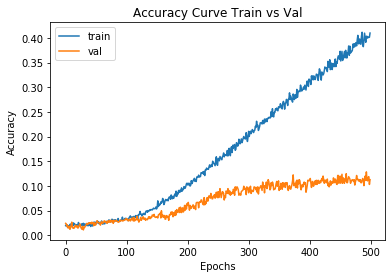

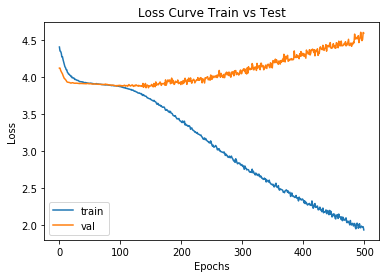

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 4794)              0         
_________________________________________________________________
dense_65 (Dense)             (None, 64)                306880    
_________________________________________________________________
batch_normalization_33 (Batc (None, 64)                256       
_________________________________________________________________
dropout_33 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_66 (Dense)             (None, 128)               8320      
_________________________________________________________________
batch_normalization_34 (Batc (None, 128)               512       
_________________________________________________________________
dropout_34 (Dropout)         (None, 128)               0   

Epoch 67/500
 - 3s - loss: 3.9036 - acc: 0.0262 - val_loss: 3.9243 - val_acc: 0.0194
Epoch 68/500
 - 3s - loss: 3.9040 - acc: 0.0278 - val_loss: 3.9239 - val_acc: 0.0131
Epoch 69/500
 - 3s - loss: 3.9035 - acc: 0.0254 - val_loss: 3.9241 - val_acc: 0.0163
Epoch 70/500
 - 3s - loss: 3.9074 - acc: 0.0253 - val_loss: 3.9239 - val_acc: 0.0142
Epoch 71/500
 - 3s - loss: 3.9008 - acc: 0.0276 - val_loss: 3.9248 - val_acc: 0.0168
Epoch 72/500
 - 3s - loss: 3.9019 - acc: 0.0229 - val_loss: 3.9245 - val_acc: 0.0178
Epoch 73/500
 - 3s - loss: 3.9009 - acc: 0.0292 - val_loss: 3.9249 - val_acc: 0.0173
Epoch 74/500
 - 3s - loss: 3.9030 - acc: 0.0251 - val_loss: 3.9249 - val_acc: 0.0189
Epoch 75/500
 - 3s - loss: 3.9007 - acc: 0.0289 - val_loss: 3.9244 - val_acc: 0.0178
Epoch 76/500
 - 3s - loss: 3.9014 - acc: 0.0312 - val_loss: 3.9241 - val_acc: 0.0168
Epoch 77/500
 - 3s - loss: 3.9011 - acc: 0.0271 - val_loss: 3.9240 - val_acc: 0.0205
Epoch 78/500
 - 3s - loss: 3.8966 - acc: 0.0260 - val_loss: 3.924

Epoch 163/500
 - 2s - loss: 3.6213 - acc: 0.0660 - val_loss: 4.1232 - val_acc: 0.0210
Epoch 164/500
 - 2s - loss: 3.6183 - acc: 0.0595 - val_loss: 4.1137 - val_acc: 0.0184
Epoch 165/500
 - 2s - loss: 3.6167 - acc: 0.0662 - val_loss: 4.1218 - val_acc: 0.0210
Epoch 166/500
 - 3s - loss: 3.6289 - acc: 0.0655 - val_loss: 4.1047 - val_acc: 0.0231
Epoch 167/500
 - 3s - loss: 3.6326 - acc: 0.0703 - val_loss: 4.1308 - val_acc: 0.0152
Epoch 168/500
 - 3s - loss: 3.6003 - acc: 0.0705 - val_loss: 4.1345 - val_acc: 0.0163
Epoch 169/500
 - 3s - loss: 3.6059 - acc: 0.0664 - val_loss: 4.1344 - val_acc: 0.0231
Epoch 170/500
 - 3s - loss: 3.5838 - acc: 0.0684 - val_loss: 4.1577 - val_acc: 0.0199
Epoch 171/500
 - 3s - loss: 3.5843 - acc: 0.0635 - val_loss: 4.1609 - val_acc: 0.0194
Epoch 172/500
 - 2s - loss: 3.5669 - acc: 0.0738 - val_loss: 4.1793 - val_acc: 0.0184
Epoch 173/500
 - 3s - loss: 3.5687 - acc: 0.0731 - val_loss: 4.1684 - val_acc: 0.0210
Epoch 174/500
 - 3s - loss: 3.5619 - acc: 0.0781 - val

Epoch 259/500
 - 3s - loss: 3.0844 - acc: 0.1450 - val_loss: 4.5573 - val_acc: 0.0289
Epoch 260/500
 - 3s - loss: 3.0737 - acc: 0.1387 - val_loss: 4.5554 - val_acc: 0.0283
Epoch 261/500
 - 3s - loss: 3.0766 - acc: 0.1448 - val_loss: 4.5516 - val_acc: 0.0320
Epoch 262/500
 - 3s - loss: 3.0757 - acc: 0.1432 - val_loss: 4.6303 - val_acc: 0.0299
Epoch 263/500
 - 3s - loss: 3.0865 - acc: 0.1481 - val_loss: 4.6177 - val_acc: 0.0294
Epoch 264/500
 - 3s - loss: 3.0551 - acc: 0.1497 - val_loss: 4.5742 - val_acc: 0.0341
Epoch 265/500
 - 3s - loss: 3.0501 - acc: 0.1484 - val_loss: 4.6199 - val_acc: 0.0336
Epoch 266/500
 - 3s - loss: 3.0344 - acc: 0.1539 - val_loss: 4.5970 - val_acc: 0.0320
Epoch 267/500
 - 2s - loss: 3.0290 - acc: 0.1593 - val_loss: 4.6168 - val_acc: 0.0304
Epoch 268/500
 - 2s - loss: 3.0505 - acc: 0.1486 - val_loss: 4.6005 - val_acc: 0.0289
Epoch 269/500
 - 2s - loss: 3.0328 - acc: 0.1497 - val_loss: 4.6602 - val_acc: 0.0310
Epoch 270/500
 - 2s - loss: 3.0439 - acc: 0.1474 - val

Epoch 355/500
 - 2s - loss: 2.6147 - acc: 0.2321 - val_loss: 4.9109 - val_acc: 0.0336
Epoch 356/500
 - 3s - loss: 2.6294 - acc: 0.2273 - val_loss: 4.9839 - val_acc: 0.0352
Epoch 357/500
 - 3s - loss: 2.6054 - acc: 0.2325 - val_loss: 4.9685 - val_acc: 0.0357
Epoch 358/500
 - 3s - loss: 2.5619 - acc: 0.2493 - val_loss: 4.9303 - val_acc: 0.0352
Epoch 359/500
 - 3s - loss: 2.5951 - acc: 0.2376 - val_loss: 4.9703 - val_acc: 0.0320
Epoch 360/500
 - 3s - loss: 2.5671 - acc: 0.2424 - val_loss: 4.9789 - val_acc: 0.0346
Epoch 361/500
 - 2s - loss: 2.5998 - acc: 0.2367 - val_loss: 4.9529 - val_acc: 0.0357
Epoch 362/500
 - 3s - loss: 2.5738 - acc: 0.2473 - val_loss: 4.9900 - val_acc: 0.0331
Epoch 363/500
 - 3s - loss: 2.5654 - acc: 0.2475 - val_loss: 5.0350 - val_acc: 0.0325
Epoch 364/500
 - 3s - loss: 2.5513 - acc: 0.2466 - val_loss: 4.9649 - val_acc: 0.0341
Epoch 365/500
 - 3s - loss: 2.5546 - acc: 0.2487 - val_loss: 5.0309 - val_acc: 0.0336
Epoch 366/500
 - 3s - loss: 2.5549 - acc: 0.2399 - val

Epoch 451/500
 - 2s - loss: 2.2403 - acc: 0.3167 - val_loss: 5.2047 - val_acc: 0.0414
Epoch 452/500
 - 2s - loss: 2.2456 - acc: 0.3200 - val_loss: 5.2473 - val_acc: 0.0357
Epoch 453/500
 - 2s - loss: 2.2030 - acc: 0.3342 - val_loss: 5.2054 - val_acc: 0.0383
Epoch 454/500
 - 2s - loss: 2.2215 - acc: 0.3241 - val_loss: 5.2018 - val_acc: 0.0388
Epoch 455/500
 - 3s - loss: 2.1936 - acc: 0.3290 - val_loss: 5.1221 - val_acc: 0.0404
Epoch 456/500
 - 3s - loss: 2.2139 - acc: 0.3324 - val_loss: 5.2238 - val_acc: 0.0352
Epoch 457/500
 - 3s - loss: 2.1972 - acc: 0.3272 - val_loss: 5.2802 - val_acc: 0.0404
Epoch 458/500
 - 3s - loss: 2.1994 - acc: 0.3344 - val_loss: 5.1791 - val_acc: 0.0383
Epoch 459/500
 - 3s - loss: 2.1921 - acc: 0.3229 - val_loss: 5.2078 - val_acc: 0.0378
Epoch 460/500
 - 3s - loss: 2.2014 - acc: 0.3342 - val_loss: 5.2902 - val_acc: 0.0362
Epoch 461/500
 - 3s - loss: 2.1999 - acc: 0.3249 - val_loss: 5.2624 - val_acc: 0.0420
Epoch 462/500
 - 3s - loss: 2.1633 - acc: 0.3478 - val

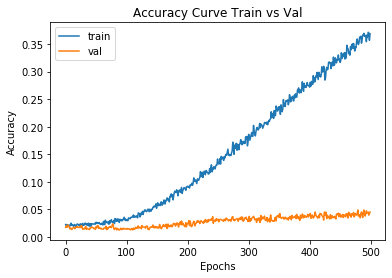

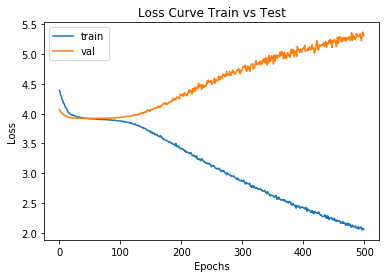

In [26]:
score_im, history_im = fit_alexNet(X_train_cb, X_test_im, y_train_cb, y_test_im)
print(f"Imagery Accuracy: {score_im}")
file_name = "Results_IMGS/Acc_AlexNet_Combined_Train_Imagery_Test.png"
plot_acc(history_im, file_name)
file_name = "Results_IMGS/Loss_AlexNet_Combined_Train_Imagery_Test.png"
plot_loss(history_im, file_name)


score_pt, history_pt = fit_alexNet(X_train_cb, X_test_pt, y_train_cb, y_test_pt)
print(f"Perception Accuracy: {score_pt}")
file_name = "Results_IMGS/Acc_AlexNet_Combined_Train_Perception_Test.png"
plot_acc(history_pt, file_name)
file_name = "Results_IMGS/Loss_AlexNet_Combined_Train_Perception_Test.png"
plot_loss(history_pt, file_name)

## 1-Layer MLP

In [20]:
def one_layer_mlp(input_size = (4466,)):
    inputs = Input(input_size)
    dense1 = Dense(64, activation='relu', kernel_initializer = 'he_normal')(inputs)
    bn1 = BatchNormalization()(dense1)
    dropout1 = Dropout(0.5)(bn1)
    dense2 = Dense(50, activation='softmax')(dropout1)

    model = Model(input = inputs, output = dense2)
    model.compile(loss='sparse_categorical_crossentropy', optimizer = keras.optimizers.Adam(lr = 1e-4), metrics=['accuracy'])

    return model

In [21]:
def fit_one_layer_mlp(X_train, X_test, y_train, y_test):
    model = one_layer_mlp(input_size=(X_train.shape[1],))
    model.summary()
    model = one_layer_mlp(input_size=(X_train.shape[1],))
    history = model.fit(X_train, y_train, batch_size=16, epochs=100, validation_data=(X_test, y_test), shuffle=True, verbose=2)
    
    score = model.evaluate(X_test, y_test, batch_size=16)    
    return score, history

def plot_acc(history, file_name):
    plt.plot(history.history['acc'], label="train")
    plt.plot(history.history['val_acc'], label="val")
    plt.title("Accuracy Curve Train vs Val")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.savefig(file_name, dpi=300)
    plt.show()
    
def plot_loss(history, file_name):
    plt.plot(history.history['loss'], label="train")
    plt.plot(history.history['val_loss'], label="val")
    plt.title("Loss Curve Train vs Test")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(file_name, dpi=300)
    plt.show()

### Experiment A. (Perception Train Perception Test)

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 4794)              0         
_________________________________________________________________
dense_81 (Dense)             (None, 64)                306880    
_________________________________________________________________
batch_normalization_41 (Batc (None, 64)                256       
_________________________________________________________________
dropout_41 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_82 (Dense)             (None, 50)                3250      
Total params: 310,386
Trainable params: 310,258
Non-trainable params: 128
_________________________________________________________________
Train on 3869 samples, validate on 1906 samples
Epoch 1/100
 - 4s - loss: 4.7382 - acc: 0.0184 - val_loss: 4.2002 - 

Epoch 85/100
 - 3s - loss: 1.4667 - acc: 0.6247 - val_loss: 3.8485 - val_acc: 0.1028
Epoch 86/100
 - 3s - loss: 1.3830 - acc: 0.6449 - val_loss: 3.9710 - val_acc: 0.0892
Epoch 87/100
 - 3s - loss: 1.3907 - acc: 0.6467 - val_loss: 3.9351 - val_acc: 0.0944
Epoch 88/100
 - 3s - loss: 1.3988 - acc: 0.6475 - val_loss: 3.9269 - val_acc: 0.0986
Epoch 89/100
 - 3s - loss: 1.4341 - acc: 0.6312 - val_loss: 3.9164 - val_acc: 0.1023
Epoch 90/100
 - 3s - loss: 1.4040 - acc: 0.6413 - val_loss: 3.9641 - val_acc: 0.0902
Epoch 91/100
 - 3s - loss: 1.3561 - acc: 0.6475 - val_loss: 3.9591 - val_acc: 0.0955
Epoch 92/100
 - 3s - loss: 1.3274 - acc: 0.6632 - val_loss: 4.0334 - val_acc: 0.0913
Epoch 93/100
 - 3s - loss: 1.3763 - acc: 0.6418 - val_loss: 4.0446 - val_acc: 0.1007
Epoch 94/100
 - 3s - loss: 1.3021 - acc: 0.6581 - val_loss: 3.9370 - val_acc: 0.0986
Epoch 95/100
 - 3s - loss: 1.3462 - acc: 0.6490 - val_loss: 4.0355 - val_acc: 0.0939
Epoch 96/100
 - 3s - loss: 1.3154 - acc: 0.6562 - val_loss: 4.033

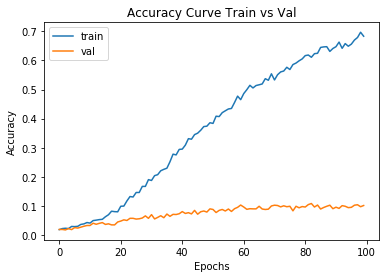

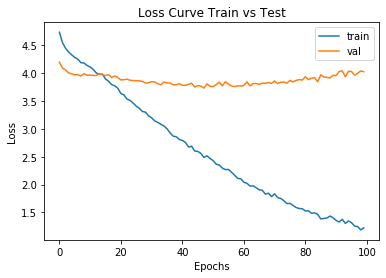

In [29]:
score, history = fit_one_layer_mlp(X_train_pt, X_test_pt, y_train_pt, y_test_pt)
print(f"Accuracy: {score}")
file_name = "Results_IMGS/Acc_1MLP_Perception_Train_Perception_Test.png"
plot_acc(history, file_name)
file_name = "Results_IMGS/Loss_1MLP_Perception_Train_Perception_Test.png"
plot_loss(history, file_name)

### Experiment B. (Imagery Train Imagery Test)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 13000)             0         
_________________________________________________________________
dense_17 (Dense)             (None, 64)                832064    
_________________________________________________________________
batch_normalization_9 (Batch (None, 64)                256       
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 50)                3250      
Total params: 835,570
Trainable params: 835,442
Non-trainable params: 128
_________________________________________________________________
Train on 335 samples, validate on 165 samples
Epoch 1/100
 - 1s - loss: 4.9925 - acc: 0.0269 - val_loss: 4.7817 - val

Epoch 85/100
 - 0s - loss: 2.0718 - acc: 0.5672 - val_loss: 4.3834 - val_acc: 0.0061
Epoch 86/100
 - 0s - loss: 2.0661 - acc: 0.5522 - val_loss: 4.4419 - val_acc: 0.0000e+00
Epoch 87/100
 - 0s - loss: 2.0138 - acc: 0.5761 - val_loss: 4.4396 - val_acc: 0.0061
Epoch 88/100
 - 0s - loss: 2.0367 - acc: 0.5552 - val_loss: 4.3588 - val_acc: 0.0061
Epoch 89/100
 - 0s - loss: 1.9985 - acc: 0.5731 - val_loss: 4.3648 - val_acc: 0.0061
Epoch 90/100
 - 0s - loss: 2.0029 - acc: 0.5701 - val_loss: 4.3402 - val_acc: 0.0121
Epoch 91/100
 - 0s - loss: 1.9724 - acc: 0.5851 - val_loss: 4.3836 - val_acc: 0.0061
Epoch 92/100
 - 0s - loss: 1.9949 - acc: 0.5821 - val_loss: 4.3588 - val_acc: 0.0000e+00
Epoch 93/100
 - 0s - loss: 1.9893 - acc: 0.5731 - val_loss: 4.3400 - val_acc: 0.0121
Epoch 94/100
 - 0s - loss: 2.0586 - acc: 0.5522 - val_loss: 4.3722 - val_acc: 0.0121
Epoch 95/100
 - 0s - loss: 1.9915 - acc: 0.5672 - val_loss: 4.4122 - val_acc: 0.0242
Epoch 96/100
 - 0s - loss: 1.9974 - acc: 0.5851 - val_los

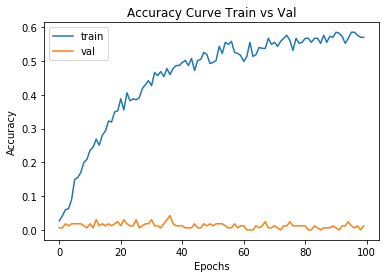

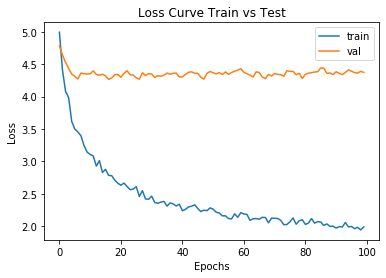

In [22]:
score, history = fit_one_layer_mlp(X_train_im, X_test_im, y_train_im, y_test_im)
print(f"Accuracy: {score}")
file_name = "Results_IMGS/Acc_1MLP_Imagery_Train_Imagery_Test.png"
plot_acc(history, file_name)
file_name = "Results_IMGS/Loss_1MLP_Imagery_Train_Imagery_Test.png"
plot_loss(history, file_name)

### Experiment C. (Perception Train Imagery Test)

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 4794)              0         
_________________________________________________________________
dense_89 (Dense)             (None, 64)                306880    
_________________________________________________________________
batch_normalization_45 (Batc (None, 64)                256       
_________________________________________________________________
dropout_45 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_90 (Dense)             (None, 50)                3250      
Total params: 310,386
Trainable params: 310,258
Non-trainable params: 128
_________________________________________________________________
Train on 3869 samples, validate on 825 samples
Epoch 1/100
 - 4s - loss: 4.7266 - acc: 0.0165 - val_loss: 4.2240 - v

Epoch 85/100
 - 3s - loss: 1.4651 - acc: 0.6263 - val_loss: 6.8862 - val_acc: 0.0230
Epoch 86/100
 - 3s - loss: 1.4696 - acc: 0.6343 - val_loss: 6.9840 - val_acc: 0.0291
Epoch 87/100
 - 3s - loss: 1.4475 - acc: 0.6283 - val_loss: 7.0103 - val_acc: 0.0267
Epoch 88/100
 - 3s - loss: 1.4287 - acc: 0.6299 - val_loss: 7.0303 - val_acc: 0.0291
Epoch 89/100
 - 3s - loss: 1.4427 - acc: 0.6296 - val_loss: 7.1242 - val_acc: 0.0267
Epoch 90/100
 - 3s - loss: 1.4263 - acc: 0.6245 - val_loss: 7.2437 - val_acc: 0.0279
Epoch 91/100
 - 3s - loss: 1.3724 - acc: 0.6464 - val_loss: 7.1697 - val_acc: 0.0206
Epoch 92/100
 - 3s - loss: 1.4039 - acc: 0.6327 - val_loss: 7.2758 - val_acc: 0.0242
Epoch 93/100
 - 3s - loss: 1.3563 - acc: 0.6511 - val_loss: 7.2435 - val_acc: 0.0279
Epoch 94/100
 - 3s - loss: 1.3503 - acc: 0.6513 - val_loss: 7.4253 - val_acc: 0.0267
Epoch 95/100
 - 3s - loss: 1.3228 - acc: 0.6549 - val_loss: 7.4644 - val_acc: 0.0279
Epoch 96/100
 - 3s - loss: 1.2982 - acc: 0.6661 - val_loss: 7.409

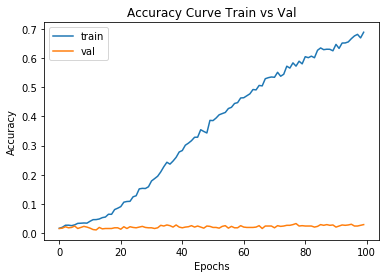

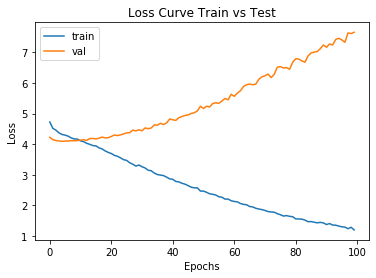

In [31]:
score, history = fit_one_layer_mlp(X_train_pt, X_test_im, y_train_pt, y_test_im)
print(f"Accuracy: {score}")
file_name = "Results_IMGS/Acc_1MLP_Perception_Train_Imagery_Test.png"
plot_acc(history, file_name)
file_name = "Results_IMGS/Loss_1MLP_Perception_Train_Imagery_Test.png"
plot_loss(history, file_name)

### Experiment D. (Combined Train Combined Test)

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 4794)              0         
_________________________________________________________________
dense_93 (Dense)             (None, 64)                306880    
_________________________________________________________________
batch_normalization_47 (Batc (None, 64)                256       
_________________________________________________________________
dropout_47 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_94 (Dense)             (None, 50)                3250      
Total params: 310,386
Trainable params: 310,258
Non-trainable params: 128
_________________________________________________________________
Train on 5544 samples, validate on 825 samples
Epoch 1/100
 - 6s - loss: 4.6842 - acc: 0.0249 - val_loss: 4.0168 - v

Epoch 85/100
 - 3s - loss: 1.3491 - acc: 0.6468 - val_loss: 2.9763 - val_acc: 0.2485
Epoch 86/100
 - 3s - loss: 1.3004 - acc: 0.6510 - val_loss: 3.0042 - val_acc: 0.2739
Epoch 87/100
 - 4s - loss: 1.2565 - acc: 0.6753 - val_loss: 2.9791 - val_acc: 0.2679
Epoch 88/100
 - 4s - loss: 1.3038 - acc: 0.6517 - val_loss: 3.0143 - val_acc: 0.2667
Epoch 89/100
 - 4s - loss: 1.2820 - acc: 0.6585 - val_loss: 2.9512 - val_acc: 0.2642
Epoch 90/100
 - 4s - loss: 1.2518 - acc: 0.6607 - val_loss: 2.9946 - val_acc: 0.2521
Epoch 91/100
 - 4s - loss: 1.2262 - acc: 0.6809 - val_loss: 3.0243 - val_acc: 0.2655
Epoch 92/100
 - 4s - loss: 1.2474 - acc: 0.6623 - val_loss: 3.0087 - val_acc: 0.2739
Epoch 93/100
 - 4s - loss: 1.2308 - acc: 0.6724 - val_loss: 3.0207 - val_acc: 0.2606
Epoch 94/100
 - 4s - loss: 1.1844 - acc: 0.6887 - val_loss: 3.0525 - val_acc: 0.2667
Epoch 95/100
 - 4s - loss: 1.1718 - acc: 0.6851 - val_loss: 3.0364 - val_acc: 0.2533
Epoch 96/100
 - 4s - loss: 1.1734 - acc: 0.6840 - val_loss: 3.093

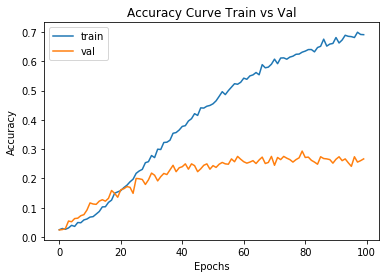

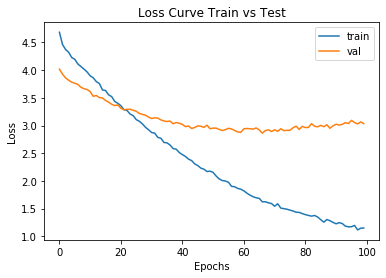

Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 4794)              0         
_________________________________________________________________
dense_97 (Dense)             (None, 64)                306880    
_________________________________________________________________
batch_normalization_49 (Batc (None, 64)                256       
_________________________________________________________________
dropout_49 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_98 (Dense)             (None, 50)                3250      
Total params: 310,386
Trainable params: 310,258
Non-trainable params: 128
_________________________________________________________________
Train on 5544 samples, validate on 1906 samples
Epoch 1/100
 - 6s - loss: 4.6219 - acc: 0.0218 - val_loss: 4.1138 - 

Epoch 85/100
 - 4s - loss: 1.3486 - acc: 0.6394 - val_loss: 3.9843 - val_acc: 0.0892
Epoch 86/100
 - 4s - loss: 1.3283 - acc: 0.6537 - val_loss: 4.0464 - val_acc: 0.0876
Epoch 87/100
 - 4s - loss: 1.3297 - acc: 0.6443 - val_loss: 4.1406 - val_acc: 0.0782
Epoch 88/100
 - 4s - loss: 1.3421 - acc: 0.6465 - val_loss: 4.0600 - val_acc: 0.0876
Epoch 89/100
 - 4s - loss: 1.3488 - acc: 0.6475 - val_loss: 4.0219 - val_acc: 0.0845
Epoch 90/100
 - 4s - loss: 1.2758 - acc: 0.6611 - val_loss: 4.0497 - val_acc: 0.0950
Epoch 91/100
 - 4s - loss: 1.2855 - acc: 0.6575 - val_loss: 4.1874 - val_acc: 0.0876
Epoch 92/100
 - 4s - loss: 1.2823 - acc: 0.6551 - val_loss: 4.1086 - val_acc: 0.0834
Epoch 93/100
 - 4s - loss: 1.2419 - acc: 0.6708 - val_loss: 4.1529 - val_acc: 0.0813
Epoch 94/100
 - 4s - loss: 1.2290 - acc: 0.6658 - val_loss: 4.1095 - val_acc: 0.0845
Epoch 95/100
 - 4s - loss: 1.2429 - acc: 0.6587 - val_loss: 4.0709 - val_acc: 0.0871
Epoch 96/100
 - 4s - loss: 1.2207 - acc: 0.6697 - val_loss: 4.087

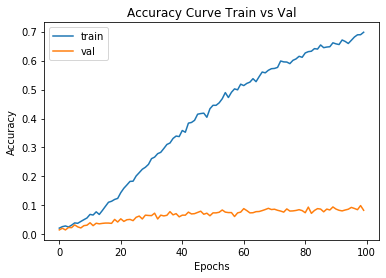

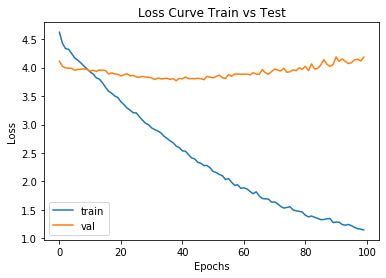

In [32]:
score_im, history_im = fit_one_layer_mlp(X_train_cb, X_test_im, y_train_cb, y_test_im)
print(f"Imagery Accuracy: {score_im}")
file_name = "Results_IMGS/Acc_1MLP_Combined_Train_Imagery_Test.png"
plot_acc(history_im, file_name)
file_name = "Results_IMGS/Loss_1MLP_Combined_Train_Imagery_Test.png"
plot_loss(history_im, file_name)

score_pt, history_pt = fit_one_layer_mlp(X_train_cb, X_test_pt, y_train_cb, y_test_pt)
print(f"Perception Accuracy: {score_pt}")
file_name = "Results_IMGS/Acc_1MLP_Combined_Train_Perception_Test.png"
plot_acc(history_pt, file_name)
file_name = "Results_IMGS/Loss_1MLP_Combined_Train_Perception_Test.png"
plot_loss(history_pt, file_name)

# Using correlation for prediction

In [23]:
def get_averaged_feature(pred_y, true_y, labels):
    '''Return category-averaged features'''

    labels_set = np.unique(labels)

    pred_y_av = np.array([np.mean(pred_y[labels == c, :], axis=0) for c in labels_set])
    true_y_av = np.array([np.mean(true_y[labels == c, :], axis=0) for c in labels_set])

    return pred_y_av, true_y_av, labels_set